# Substructure effect on source reconstruction

**HST mock data**

This notebooks aims to assess whether a substructure in the lens and not considered in the modelling can cause non-negligible effects on the source reconstruction.

In [1]:
__author__ = 'aymgal'

import os
import scipy
import copy
import numpy as np
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm
import time

from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.Numerics.grid import RegularGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
import lenstronomy.Util.util as lenstro_util
from lenstronomy.Util import kernel_util, image_util, mask_util
from lenstronomy.Plots import lens_plot, chain_plot

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Lensing.lensing_operator import LensingOperator
from slitronomy.Util.plot_util import nice_colorbar, nice_colorbar_residuals, log_cmap
from slitronomy.Util import metrics_util

import fixed_param
import substruct_util
import source_util

np.random.seed(18)

%matplotlib inline

## Some global parameters to play with

General parameters:
- `data_type`: choice of target imaging data: `'HST'` or `'ELT'`
- `complex_source_type`: choice of the source galaxy among:
    - `'highres-single'`: a single galaxy from HST high-res image (same as Time Delay Lens Modelling Challenge mocks).
    - `'galsim-single'`: a single galaxy generated with `galsim`.
    - `'galsim-satellite'`: two side-by-side galaxies generated with `galsim`. A typical case where wavelets reconstruction perform well.
    - `'cuspy-profile'`: two superimposed circular Sérsic profiles, tweaked such as it produces a very concentrated light distribution. Another typical case where the reconstruction outperforms parametric methods such as shapelets.
- `perfect_seeing`: if `True`, no PSF effect are included in simulation nor modelling.
- `re_optimize_lens_model`: if `True`, performs a refinement of the lens model prior to reconstruction.
- `subgrid_res_source`: image pixel size to source pixel size ratio (aka subgrid resolution of source plane).

In [17]:
data_type = 'ELT'
complex_source_type = 'highres-single'  # 'highres-single', 'galsim-single', 'galsim-satellite', 'cuspy-profile'

subgrid_res_source = 3
perfect_seeing = False
re_optimize_lens_model = True

substruct_mass_range = np.logspace(7, 11, 3)  # in solar masses


In [18]:
# choice of colormaps for image plots
cmap_default = plt.get_cmap('viridis')
cmap_residuals = plt.get_cmap('RdBu_r')
cmap_flux = plt.get_cmap('cubehelix')
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.deepcopy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='gray', alpha=1)  # emphasize -negative pixels when in log scale

def resize_psf_kernel(kernel, new_size, replace_negative=1e-15):
    """resize a PSF kernel image"""
    if new_size % 2 == 0:
        # make sure the new size is always an odd number
        new_size += 1
    dirac = np.zeros((new_size, new_size), dtype=kernel.dtype)
    dirac[new_size//2, new_size//2] = 1
    kernel_resized = scipy.signal.fftconvolve(dirac, kernel, mode='same')  # make sure it is centered on a pixel
    kernel_resized[kernel_resized < 0] = replace_negative
    return kernel_resized / kernel_resized.sum()  # normalize so sum is 1

def get_HST_psf_kernel():
    with pf.open(os.path.join('data', 'PSFs', 'PSF_HST_F160W_tinytim.fits')) as f:
        psf_kernel = f[0].data
    # remove pixels near edges that display artifacts
    psf_kernel = psf_kernel[8:-8, 8:-8]
    # makes sure sum is 1
    psf_kernel /= psf_kernel.sum()
    return psf_kernel

def get_ELT_psf_kernel(size_kernel=159):
    # using SimCADO file to get E-ELT simulated PSF for the MICADO instrument (from MAORY simulation)
    with pf.open(os.path.join('data', 'PSFs', 'PSF_MCAO_H_Strehl21.fits')) as f:
        psf_kernel_maory_raw = f[0].data.astype(np.float32)
    psf_kernel_maory_odd = psf_kernel_maory_raw[1:, 1:]
    psf_kernel_maory_odd /= psf_kernel_maory_odd.sum()  # normalize so sum is 1
    # resize the PSF to smaller kernel
    psf_kernel = resize_psf_kernel(psf_kernel_maory_odd, size_kernel)
    return psf_kernel

## Define image size, resolution, seeing, and instrument properties

**HST**: Instrument and observational setting inspired by J1537-3010 F160W science frame (after drizzling) and the WFC3/UR Exposure Time Calculator, for 4x500s exposures before drizzling.

**E-ELT**: Instrument and observational setting inspired by Meng, Treu et al. 2015 (but those were for another very large telescope, the TMT) and Deep et al. 2011 (gives some limiting mag at a given exposure time), and the ELT Exposure Time Calculator for H band on the MICADO instrument (https://www.eso.org/observing/etc/bin/simu/elt_ima).

However `'sky_brightness'` and `'magnitude_zero_point'` may not be accurate.

In [19]:
# data specifics
if data_type == 'HST':
    num_pix = 110  # number of side pixels
    delta_pix = 0.08  # final pixel size in arcsec
elif data_type == 'ELT':
    num_pix = 2200  # number of side pixels
    delta_pix = 0.004  # final pixel size in arcsec

num_pix_source = int(num_pix*subgrid_res_source)  # (maximum) number of side pixels for source plane


# seeing specifics
if perfect_seeing:
    psf_type = 'NONE'
    psf_kernel = None
else:
    psf_type = 'PIXEL'
    if data_type == 'HST':
        psf_kernel = get_HST_psf_kernel()
    elif data_type == 'ELT':
        psf_kernel = get_ELT_psf_kernel()
        
        
# observational and instrumentation settings
if data_type == 'HST':
    # HST WCF3 F160W band
    kwargs_simulation = {
        # instrument-related
        #'read_noise': 80,  # std of noise generated by read-out (in units of electrons)
        'ccd_gain': 2.5,  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
        'pixel_scale': delta_pix,  # scale (in arcseonds) of pixels

        # observation-related
        #'sky_brightness': 21.7,  # sky brightness (in magnitude per square arcseconds)
        'exposure_time': 500,  # exposure time per image (in seconds)
        'magnitude_zero_point': 27,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
        'num_exposures': 4,  # number of exposures that are combined
        'data_count_unit': 'ADU',  # 'ADU' or 'e-'

        # or instead of 'read_noise' and 'sky_brightness'
        'background_noise': 0.05,

        'psf_type': psf_type,  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
        'kernel_point_source': psf_kernel  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
    }
    supersampling_factor_sim = 3
    
elif data_type == 'ELT':
    # ELT MICADO H band
    kwargs_simulation = {
        # instrument-related
        'read_noise': 3,  # std of noise generated by read-out (in units of electrons)
        'ccd_gain': 1,  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
        'pixel_scale': delta_pix,  # scale (in arcseonds) of pixels

        # observation-related
        'sky_brightness': 25,  # sky brightness (in magnitude per square arcseconds), depends on exposure time
        'exposure_time': 1200,  # exposure time per image (in seconds)
        'magnitude_zero_point': 34,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
        'num_exposures': 1,  # number of exposures that are combined
        'data_count_unit': 'ADU',  # 'ADU' or 'e-'

        # or instead of 'read_noise' and 'sky_brightness'
        #'background_noise': 0.04,

        'psf_type': 'PIXEL',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
        'kernel_point_source': psf_kernel  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
    }
    supersampling_factor_sim = 1

## Lens model, substructures, source position and magnitude

Those parameters are mainly defined on the `fixed_param` module.

In [20]:
# model without substructure ('macro' model)
lens_model_list_macro = fixed_param.lens_model_list  # list of profile names
kwargs_lens_macro = fixed_param.kwargs_lens  # parameter values
lens_model_class_macro = LensModel(lens_model_list=lens_model_list_macro)
theta_E_macro = kwargs_lens_macro[0]['theta_E']

# true model with substructure
ra_substruct, dec_substruct = 0, theta_E_macro
profile_substruct = fixed_param.profile_substruct
lens_model_list = lens_model_list_macro + [profile_substruct]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# build the list of parameter values for each substructure mass
kwargs_lens_range = []
for mass in substruct_mass_range:
    kwargs_lens_updated, c = substruct_util.update_kwargs_with_substruct(kwargs_lens_macro, mass, ra_substruct, dec_substruct,
                                                                         profile=profile_substruct, concentration_relation='Correr')
    #print(kwargs_lens_updated[-1])
    kwargs_lens_range.append(kwargs_lens_updated)

# parameters for the source
galaxy_name = fixed_param.galaxy_name
ra_source, dec_source = fixed_param.ra_source, fixed_param.dec_source
mag_source = fixed_param.mag_source

# parameters for the mask
mask_outer_radius, mask_inner_radius = fixed_param.mask_outer_radius, fixed_param.mask_inner_radius

## Visualize lens model

### Macro-model only

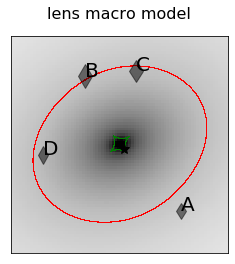

In [21]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.set_title("lens macro model", fontsize=16)
lens_plot.lens_model_plot(ax, lens_model_class_macro, kwargs_lens_macro, 
                          numPix=80, deltaPix=0.06,   # play with these to zoom in/ou in the figure, or increase resolution
                          sourcePos_x=ra_source, sourcePos_y=dec_source,
                          point_source=True, with_caustics=True, coord_inverse=False)
plt.show()

### With substructures added

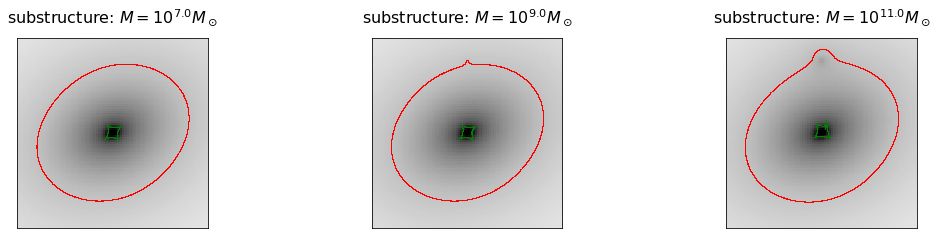

In [22]:
fig = plt.figure(figsize=(18, 3.5))
for i, (mass_plot, kwargs_lens_plot) in enumerate(zip(substruct_mass_range[-5:], kwargs_lens_range[-5:])):  
    ax = plt.subplot(1, len(substruct_mass_range[-5:]), i+1)
    pow_str = "{:.1f}".format(np.log10(mass_plot))
    title = "substructure: " + r"$M=10^{"+pow_str+"}M_\odot$"
    ax.set_title(title, fontsize=16)
    lens_plot.lens_model_plot(ax, lens_model_class, kwargs_lens_plot, 
                              numPix=80, deltaPix=0.06,   # play with these to zoom in/ou in the figure, or increase resolution
                              sourcePos_x=ra_source, sourcePos_y=dec_source,
                              point_source=False, with_caustics=True, coord_inverse=False)
plt.show()

## Setup the source surface brightness

This is performed in an external module. 

In [23]:
if complex_source_type == 'highres-single':
    source_model_list, kwargs_source = source_util.prepare_highres_source(ra_source, dec_source, galaxy_name=galaxy_name, magnitude=mag_source)
elif complex_source_type == 'galsim-single' and data_type == 'HST':
    source_model_list, kwargs_source = source_util.prepare_galsim_source(ra_source, dec_source, galsim_index=31)
elif complex_source_type == 'galsim-satellite' and data_type == 'HST':
    source_model_list, kwargs_source = source_util.prepare_galsim_source(ra_source, dec_source, galsim_index=31, with_satellite=True, galsim_index_satellite=5)
elif complex_source_type == 'cuspy-profile' and data_type == 'HST':
    source_model_list, kwargs_source = source_util.prepare_cuspy_source(ra_source, dec_source)

source_model_class = LightModel(light_model_list=source_model_list)

## Setup lens surface brightness

No lens light in this case.

In [24]:
#lens_light_model_list = []
#kwargs_lens_light = [{}]
#lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

## Simluate the range of images

### Define a function that generates all required products fiven a mass model

In [25]:
def simulate_single(lens_model_list_, kwargs_lens_, source_model_list_, kwargs_source_, 
                    display_summary=False, noise_seed=None):
    # wrap up the model components
    kwargs_model_sim = {
        'lens_model_list': lens_model_list_,
        'source_light_model_list': source_model_list_,
        #'lens_light_model_list': lens_light_model_list_,
    }

    # instantiate the simulation class
    sim_class = SimAPI(num_pix, kwargs_simulation, kwargs_model_sim)

    # get the image model class
    imsim_class = sim_class.image_model_class(kwargs_numerics={'supersampling_factor': supersampling_factor_sim})

    # get other useful classes
    data_class = sim_class.data_class
    psf_class = sim_class.psf_class

    kwargs_source_amp = copy.deepcopy(kwargs_source_)
    if 'magnitude' in kwargs_source_[0]:
        # convert magnitudes into internal amplitude units based on instrumental settings
        _, kwargs_source_amp, _ = sim_class.magnitude2amplitude(kwargs_source_mag=kwargs_source_amp)
    
    # simulate the noise-free image
    image_sim_no_noise = imsim_class.image(kwargs_lens_, kwargs_source_amp, kwargs_lens_light=None, kwargs_ps=None)

    # add realistic noise
    image_sim = image_sim_no_noise + sim_class.noise_for_model(model=image_sim_no_noise, seed=noise_seed)

    # update the data class with the simulated image
    data_class.update_data(image_sim)
    
    # square root of noise covariance matrix
    noise_map_sim = np.sqrt(data_class.C_D)
    
    # extract coordinates properties for orientation and pixel to angle conversion
    ra_at_xy_0, dec_at_xy_0 = data_class.radec_at_xy_0
    transform_pix2angle = data_class.transform_pix2angle

    # from these properties, create grid objects for image plane and source plane
    image_grid = RegularGrid(num_pix, num_pix, transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
    source_grid = RegularGrid(num_pix, num_pix, transform_pix2angle, ra_at_xy_0, dec_at_xy_0, 
                              supersampling_factor=subgrid_res_source)

    # extract 1D coordinates arrays for easy evaluation surface brightness profiles
    ra_grid, dec_grid = image_grid.coordinates_evaluate
    ra_grid_hd, dec_grid_hd = source_grid.coordinates_evaluate
    
    # true source flux in higher resolution grid
    source_sim = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_amp)
    source_sim = lenstro_util.array2image(source_sim)

    # flux normalization of true source for proper comparison with pixel-based reconstruction
    source_sim_comp = source_sim * delta_pix**2
    
    # mask
    if mask_outer_radius is not None:
        likelihood_mask = mask_util.mask_sphere(lenstro_util.array2image(ra_grid), 
                                                lenstro_util.array2image(dec_grid), 
                                                center_x=0, center_y=0, r=mask_outer_radius)
        if mask_inner_radius is not None:
            likelihood_mask -= mask_util.mask_sphere(lenstro_util.array2image(ra_grid), 
                                                     lenstro_util.array2image(dec_grid), 
                                                     center_x=0, center_y=0, r=mask_inner_radius)
    else:
        likelihood_mask = None
        
    # display products
    if display_summary:
        fig = plt.figure(figsize=(18, 3.5))

        ax = plt.subplot(1, 4, 1)
        ax.set_title("image plane, convolved")
        im = ax.imshow(image_sim*likelihood_mask, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
        nice_colorbar(im)

        ax = plt.subplot(1, 4, 2)
        ax.set_title("source plane, unconvolved")
        im = ax.imshow(source_sim_comp, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
        nice_colorbar(im)

        ax = plt.subplot(1, 4, 3)
        ax.set_title("noise map")
        im = ax.imshow(noise_map_sim, origin='lower', cmap=cmap_default)
        nice_colorbar(im)

        ax = plt.subplot(1, 4, 4)
        ax.set_title("PSF kernel")
        im = ax.imshow(psf_class.kernel_point_source, origin='lower', 
                       cmap=cmap_default, norm=LogNorm(1e-8))
        nice_colorbar(im)

        plt.show()
    
    return {'data_class': data_class, 'psf_class': psf_class, 'source_truth': source_sim_comp, 'likelihood_mask': likelihood_mask}


## Reconstruction of the source galaxy

### Define a function that performs source reconstruction gven data and mass model

In [26]:
def solve_pixelbased(simulation, lens_model_class_, kwargs_lens_, display_summary=False):
    
    data_class_ = simulation['data_class']
    psf_class_ = simulation['psf_class']
    source_truth = simulation['source_truth']
    likelihood_mask = simulation['likelihood_mask']
    
    source_model_list_sparsefit = ['STARLETS']
    kwargs_starlets_source = {'n_scales': 6, 'n_pixels': data_class_.data.size*subgrid_res_source**2}
    kwargs_source_sparsefit = [kwargs_starlets_source]
    source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

    kwargs_special_sparsefit = {
        'delta_x_source_grid': 0,
        'delta_y_source_grid': 0,
    }

    kwargs_sparse_solver = {
        'include_regridding_error': False,
        'source_interpolation': 'bilinear',
        'subgrid_res_source': subgrid_res_source,
        'minimal_source_plane': False,
        'min_num_pix_source': 30,
        'min_threshold': 3,
        'threshold_increment_high_freq': 1,
        'threshold_decrease_type': 'exponential',
        'sparsity_prior_norm': 1,
        'num_iter_source': 20,
        'num_iter_weights': 2,
        'verbose': False,
        'show_steps': False,
        'thread_count': 8,  # number of processors
    }

    imageSparseFit = ImageSparseFit(data_class_, psf_class=psf_class_, 
                                    lens_model_class=lens_model_class_,
                                    source_model_class=source_model_class_sparsefit,
                                    likelihood_mask=likelihood_mask,
                                    kwargs_sparse_solver=kwargs_sparse_solver)
    
    # launch solver
    #start_time = time.time()
    solver_results = imageSparseFit.image_sparse_solve(kwargs_lens_, 
                                                       kwargs_source=kwargs_source_sparsefit,
                                                       kwargs_lens_light=None,
                                                       kwargs_ps=None,
                                                       kwargs_special=kwargs_special_sparsefit)
    #end_time = time.time()
    #print("Runtime : {:.3f} s".format(end_time-start_time))
    
    sparseSolver = imageSparseFit.sparseSolver
    
    # display summary plot
    if display_summary:
        fig = sparseSolver.plot_results(log_scale=True, fontsize=16,
                                        vmin_res=-6, vmax_res=6,
                                        vmin_image=1e-2, vmax_image=1e1, 
                                        vmin_source=1e-2, vmax_source=1e1,
                                        with_history=False)
        plt.show()
    
    # get model maps
    image_model = sparseSolver.image_model(unconvolved=False)
    source_model = sparseSolver.source_model
    normalized_residuals = sparseSolver.normalized_residuals_model
    
    # use the following lines instead if a mask was used
    #source_model = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
    #source_model = lenstro_util.array2image(source_model)
    
    # compute some metrics
    # reduced chi2
    num_data_points = normalized_residuals[likelihood_mask == 1].size
    red_chi2 = metrics_util.chi2_nu(normalized_residuals, num_data_points)
    # source distorsion ratio
    sdr = metrics_util.SDR(source_truth, source_model)
    
    # save for comparison
    return {'image_model': image_model, 'source_model': source_model, 'red_chi2': red_chi2, 'SDR': sdr}


### Source reconstruction of data with no substructure

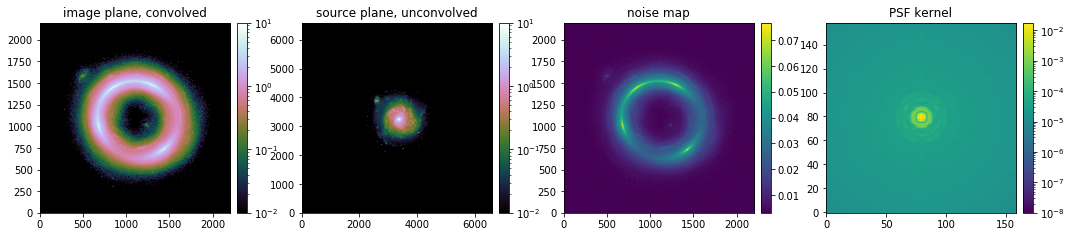

In [27]:
sim_products_base = simulate_single(lens_model_list_macro, kwargs_lens_macro, 
                                    source_model_list, kwargs_source, 
                                    display_summary=True, noise_seed=18)

Negative image pixels ? False (min = 5.68e-05)
Negative source pixels ? False (min = 0.00e+00)


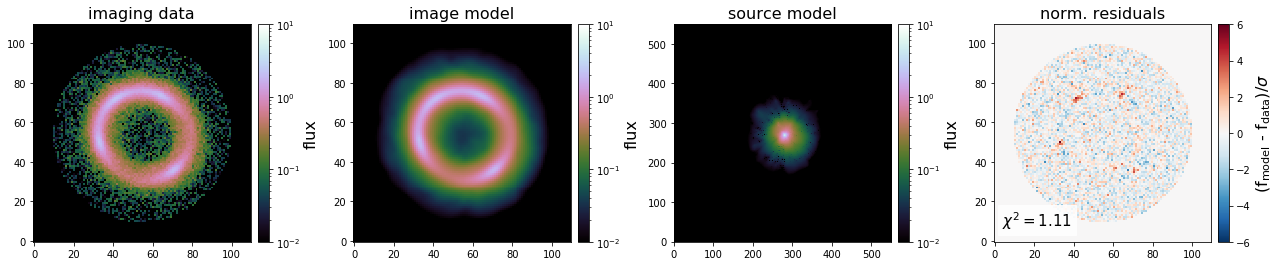

In [13]:
results_base = solve_pixelbased(sim_products_base, lens_model_class_macro, kwargs_lens_macro,  
                                display_summary=True)

### Source reconstruction of data with substructure

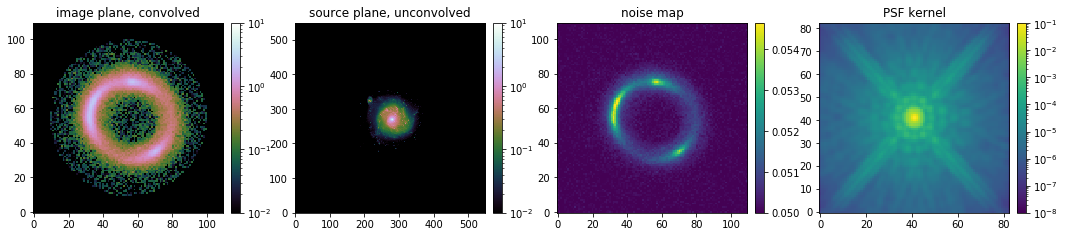

Negative image pixels ? False (min = 6.17e-05)
Negative source pixels ? False (min = 0.00e+00)


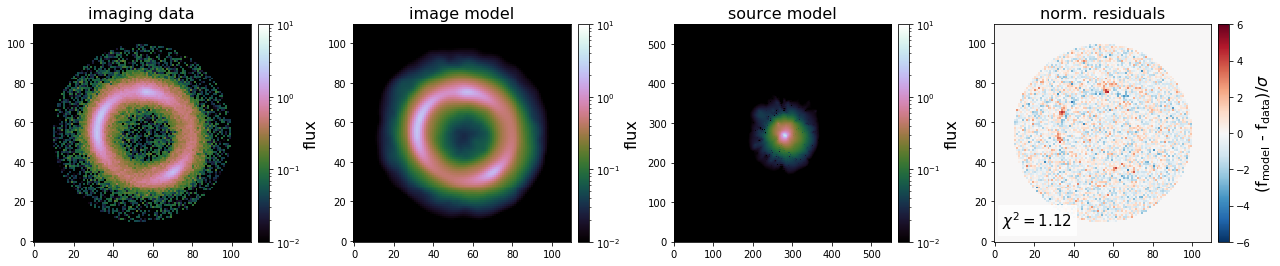

In [14]:
sim_products_substruct = simulate_single(lens_model_list, kwargs_lens_range[-1],
                                    source_model_list, kwargs_source, 
                                    display_summary=True, noise_seed=18)
results_base = solve_pixelbased(sim_products_substruct, lens_model_class, kwargs_lens_range[-1],  
                                display_summary=True)

### Source reconstruction of substructure data with macro model

1. simulate imaging data, for different noise realizations.
2. reconstruct the source with macro model

Negative image pixels ? False (min = 5.36e-05)
Negative source pixels ? False (min = 0.00e+00)


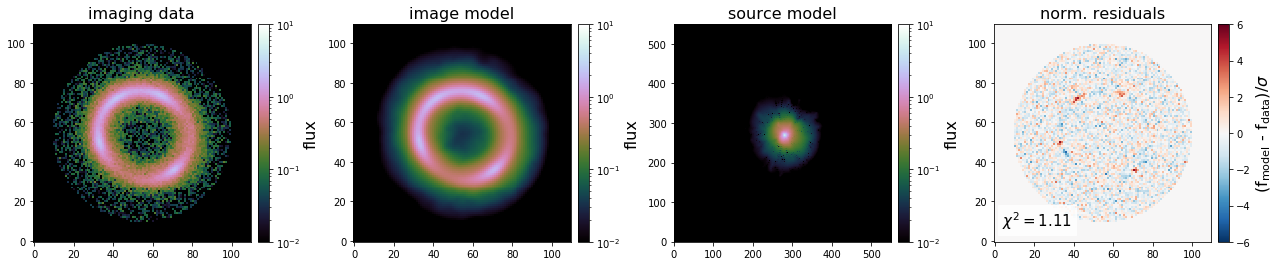

Negative image pixels ? False (min = 5.69e-05)
Negative source pixels ? False (min = 0.00e+00)


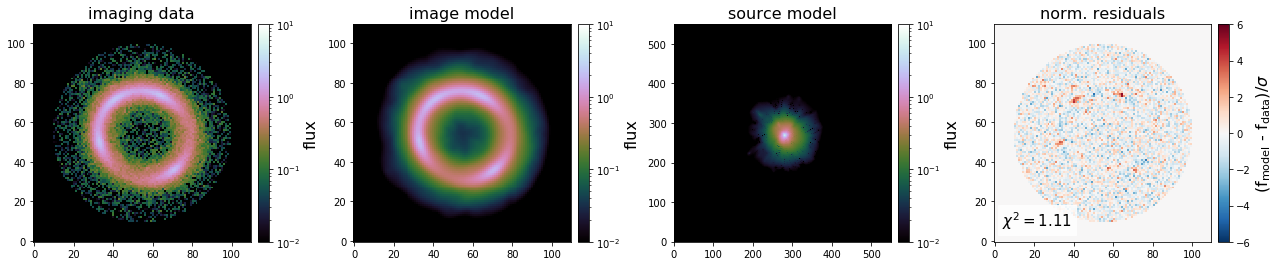

Negative image pixels ? False (min = 5.64e-05)
Negative source pixels ? False (min = 0.00e+00)


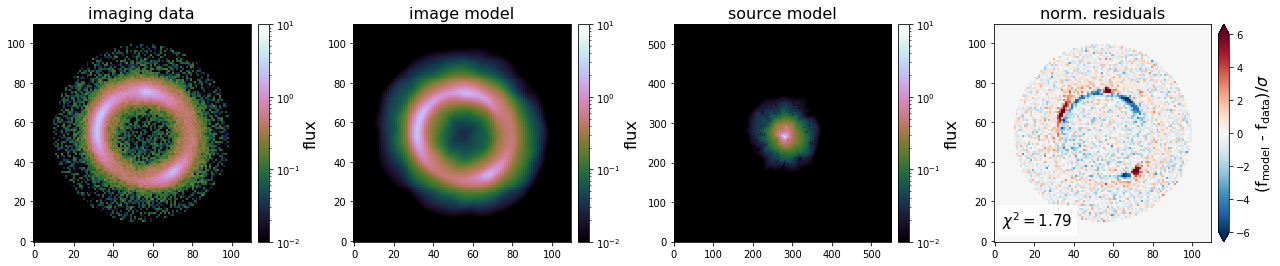

In [15]:
num_positions = 1
num_realizations = 1

ra_range  = [0] * num_positions
dec_range = [theta_E_macro]
num_positions = len(dec_range)

metrics_for_positions = {}
for (ra_substruct_var, dec_substruct_var) in zip(ra_range, dec_range):
    
    # all results will be put in this list
    metrics_mean_range, metrics_std_range = [], []

    for i, mass in enumerate(substruct_mass_range):
        
        # gather parameters of the mass model for current loop
        kwargs_lens_var, _ = substruct_util.update_kwargs_with_substruct(kwargs_lens_macro, mass, ra_substruct_var, dec_substruct_var, 
                                                                         profile=profile_substruct, concentration_relation='Correr')

        metrics_sub = []

        for _ in range(num_realizations):
            
            noise_seed = None # will generate new noise each iterations
            sim_products = simulate_single(lens_model_list, kwargs_lens_var, 
                                           source_model_list, kwargs_source, 
                                           display_summary=False, noise_seed=noise_seed)

            results = solve_pixelbased(sim_products, lens_model_class_macro, kwargs_lens_macro, 
                                       display_summary=True)

            metrics_sub.append([results['red_chi2'], results['SDR']])

        means = np.mean(metrics_sub, axis=0)
        stds = np.std(metrics_sub, axis=0)
        metrics_mean_range.append(means)
        metrics_std_range.append(stds)

    metrics_mean_range = np.array(metrics_mean_range).T
    metrics_std_range = np.array(metrics_std_range).T
    
    key = '({:.2f}, {:.2f})'.format(ra_substruct_var, dec_substruct_var)
    metrics_for_positions[key] = (metrics_mean_range, metrics_std_range)
    

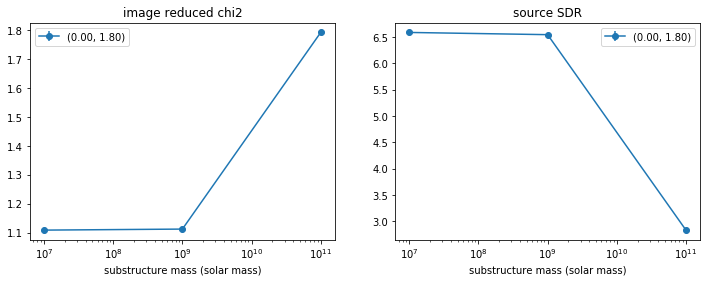

In [16]:
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

for label, data in metrics_for_positions.items():
    ax1.set_title("image reduced chi2")
    ax1.errorbar(substruct_mass_range, data[0][0, :], yerr=data[1][0, :], marker='o', label=label)
    ax1.set_xscale('log')
    ax1.set_xlabel("substructure mass (solar mass)")

    ax2.set_title("source SDR")
    ax2.errorbar(substruct_mass_range, data[0][1, :], yerr=data[1][1, :], marker='o', label=label)
    ax2.set_xscale('log')
    ax2.set_xlabel("substructure mass (solar mass)")

ax1.legend()
ax2.legend()
plt.show()